## 1. File description 




## 0. Import module and setting notebook preferences

### 0.1 Import modules

In [1]:
import src.useful as su
import src.labelling as sl
import src.image as si
import src.model as sm 
import src.webscraping as sw
import src.viz as sv

import sqlite3
import pandas as pd 
import numpy as np
from scipy.stats import boxcox

import nltk 
from nltk.corpus import stopwords
from collections import Counter


import plotly.io as pio
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
import dtale
# from autoviz import data_cleaning_suggestions



from sklearn.preprocessing import OneHotEncoder

import re
import os
from pandarallel import pandarallel

pandarallel.initialize()
sl.Mypandas.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### 0.2 Notebook preferences

In [2]:
# Setting pandas options
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,}'.format

# Setting plotly as dark
pio.templates.default = "plotly_dark"
plotly_kwargs = {'category_orders': {"label": [-1, 0, 1, 3]},
                 'color_discrete_sequence': ['#00CC96', '#1f77b4', '#EF553B', '#FECB52']}

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

# Setting path to export viz
viz_dir = '/Users/marclamy/Desktop/code/viz/instabot/'

### 0.3 Load and consolidate the data into a single table


In [3]:
df_main = sl.load_main()
df_labels = sl.load_labels()
 
df_main = df_main.merge(df_labels, how='left', on='username')

# either fillna, either dropna, depending on the use case, comment/uncomment
# df_main['label'] = df_main['label'].fillna(-1).astype(int)
# df_main['label'] = df_main['label'].astype(str)
df_main['binary_label'] = df_main['label'].apply(lambda x: 1 if x == 3 else x)
df_main = df_main.dropna(subset='label').reset_index(drop=True)

# df_main = sl.Mypandas(df_main)


df_main = df_main.drop([col for col in df_main.columns if any([f'posts_{x}' in col for x in ['sum', 'min', 'max', 'avg', 'concat']])], axis=1)


df_main.head()

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,is_verified,label,labelling_technique,binary_label
0,adorable-jade-beluga,⁣⁣28 🇩🇪 🇪🇸 \ncapricorn 🐐 \ndallas tx📍outside 🍾...,⁣⁣28 \ncapricorn \ndallas txoutside \n“her ...,📍🇩🇪🚫🍾🇪🇸🐐,6.0,6.0,"3,164.0","4,676.0",None,mintyswraps.com,bucks finna have a repeat 🏆 👀,bucks finna have a repeat,967,👀🏆,2,2,95,76.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,UNKNOWN,None,None,None,0.0,0.0,848.5854861107655,"20,366.05166665837",0.0,0.0,label_tbl_fake,0.0
1,hysterical-glistening-bee,“moving at a pace slow for some but fast for o...,“moving at a pace slow for some but fast for o...,⬇️🚨,2.0,2.0,114.0,52.0,None,youtube.com,crazy eyes got moves lol 🤣🤣😭,crazy eyes got moves lol,1024,😭🤣,3,2,250,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,None,None,Video creator,None,1.0,1.0,NaN,NaN,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
2,little-crafty-mink,new page.,new page.,,0.0,0.0,204.0,422.0,None,None,flight is gonna be heated 😂,flight is gonna be heated,711,😂,1,1,310,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,NaN,NaN,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
3,gentle-crimson-wolf,• 9/26 💘 •,• 9/26 •,💘,1.0,1.0,211.0,586.0,None,None,someone forgot to tell the warriors they had a...,someone forgot to tell the warriors they had a...,161,😂,1,1,180,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,221.88200231501833,"5,325.16805556044",0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
4,festive-uppish-leech,stay mad bum,stay mad bum,,0.0,0.0,0.0,0.0,None,None,klay is back scary hoursss 🤪🤪,klay is back scary hoursss,166,🤪,2,1,245,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,NaN,NaN,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0


In [4]:
os.system('say "error"')
asdf

NameError: name 'asdf' is not defined

### 0.4 Counting labels

In [ ]:
unique_comments = df_main.shape[0]
unique_usernames = df_main.drop_duplicates(subset='username').shape[0]

labels = df_main['label'].value_counts()
labels_unique = df_main.drop_duplicates(subset='username')['label'].value_counts()


print(f'{unique_comments = }')
print(f'{unique_usernames = }\n')
print(f'Labels for comment \n{labels}\n')
print(f'Labels unique users \n{labels_unique}\n\n')
print(f'% comments labelled: {sum(labels)/unique_comments:.1%}')
print(f'% users labelled: {sum(labels_unique)/unique_usernames:.1%}')

## 1.0 Quick viz - Move this to part 2 for when the data is clean

### 1.X Pandas profiling

In [ ]:
# Generate report of the data
# profile = ProfileReport(df_main, title="Pandas Profiling Report")
# profile.to_file('data/pandas_profiling.html')

In [ ]:
df_main.head()

### 1.X dtale

In [ ]:
# dtale.show(df_main)

### 1.x Autoviz

In [ ]:
# import matplotlib.cm
# cmap = matplotlib.cm.get_cmap('Reds')
def left_subtract(l1,l2):
    lst = []
    for i in l1:
        if i not in l2:
            lst.append(i)
    return lst
def data_suggestions(data):
    """
    Modified by Ram Seshadri. Original idea for data suggestions module was a Kaggler.
    Many thanks to: https://www.kaggle.com/code/itkin16/catboost-on-gpu-baseline
    """
    maxx = []
    minn = []
    all_cols = list(data)
    cat_cols1 = data.select_dtypes(include='object').columns.tolist()
    cat_cols2 = data.select_dtypes(include='category').columns.tolist()
    cat_cols = list(set(cat_cols1+cat_cols2))
    ### The next line may look odd but due to different versions of pandas which
    ### treat the definition of float differently, I am forced to use this. Don't change it.
    num_cols = data.select_dtypes(include='float16').columns.tolist() + data.select_dtypes(
                    include='float32').columns.tolist() + data.select_dtypes(include='float64').columns.tolist()
    non_num_cols = left_subtract(all_cols, num_cols)
    for i in data.columns:
        if i not in cat_cols:
            ### for float and integer, no need to calculate this ##
            minn.append(0)
        else:
            minn.append(data[i].value_counts().min())
    length = len(data)
    nunik = data.nunique()
    nulls = data.isna().sum()
    df = pd.DataFrame(
        {
         #'column': list(data),
        'Nuniques': nunik,
         'NuniquePercent': (100*(nunik/length)),
         'dtype': data.dtypes,
         'Nulls' : nulls,
         'Nullpercent' : 100*(nulls/length),
         'Value counts Min':minn
        },
        columns = ['Nuniques', 'dtype','Nulls','Nullpercent', 'NuniquePercent',
                       'Value counts Min'])
    newcol = 'Data cleaning improvement suggestions'
    print('%s. Complete them before proceeding to ML modeling.' %newcol)
    mixed_cols = [col for col in data.columns if len(data[col].apply(type).value_counts()) > 1]
    df[newcol] = ''
    df['first_comma'] = ''
    if len(cat_cols) > 0:
        mask0 = df['dtype'] == 'object'
        mask1 = df['Value counts Min']/df['Nuniques'] <= 0.05
        mask4 = df['dtype'] == 'category'
        df.loc[mask0&mask1,newcol] += df.loc[mask0&mask1,'first_comma'] + 'combine rare categories'
        df.loc[mask4&mask1,newcol] += df.loc[mask4&mask1,'first_comma'] + 'combine rare categories'
        df.loc[mask0&mask1,'first_comma'] = ', '
        df.loc[mask4&mask1,'first_comma'] = ', '
    mask2 = df['Nulls'] > 0
    df.loc[mask2,newcol] += df.loc[mask2,'first_comma'] + 'fill missing'
    df.loc[mask2,'first_comma'] = ", "
    mask3 = df['Nuniques'] == 1
    df.loc[mask3,newcol] += df.loc[mask3,'first_comma'] + 'invariant values: drop'
    df.loc[mask3,'first_comma'] = ", "
    if len(non_num_cols) > 0:
        for x in non_num_cols:
            if df.loc[x, 'NuniquePercent'] == 100:
                df.loc[x, newcol] += df.loc[x,'first_comma'] + 'possible ID column: drop'
                df.loc[x,'first_comma'] = ", "
    mask5 = df['Nullpercent'] >= 90
    df.loc[mask5,newcol] += df.loc[mask5,'first_comma'] + 'very high nulls percent: drop'
    df.loc[mask5,'first_comma'] = ", "
    #### check for infinite values here #####
    inf_cols1 = np.array(num_cols)[[(data.loc[(data[col] == np.inf)]).shape[0]>0 for col in num_cols]].tolist()
    inf_cols2 = np.array(num_cols)[[(data.loc[(data[col] == -np.inf)]).shape[0]>0 for col in num_cols]].tolist()
    inf_cols = list(set(inf_cols1+inf_cols2))
    ### Check for infinite values in columns #####
    if len(inf_cols) > 0:
        for x in inf_cols:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'infinite values: drop'
            df.loc[x,'first_comma'] = ", "
    #### Check for skewed float columns #######
    skew_cols1 = np.array(num_cols)[[(np.abs(np.round(data[col].skew(), 1)) > 1
                    ) & (np.abs(np.round(data[col].skew(), 1)) <= 5) for col in num_cols]].tolist()
    skew_cols2 = np.array(num_cols)[[(np.abs(np.round(data[col].skew(), 1)) > 5) for col in num_cols]].tolist()
    skew_cols = list(set(skew_cols1+skew_cols2))
    ### Check for skewed values in columns #####
    if len(skew_cols1) > 0:
        for x in skew_cols1:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'skewed: cap or drop outliers'
            df.loc[x,'first_comma'] = ", "
    if len(skew_cols2) > 0:
        for x in skew_cols2:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'highly skewed: drop outliers or do box-cox transform'
            df.loc[x,'first_comma'] = ", "
    ##### Do the same for mixed dtype columns - they must be fixed! ##
    if len(mixed_cols) > 0:
        for x in mixed_cols:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'fix mixed data types'
            df.loc[x,'first_comma'] = ", "
    df.drop('first_comma', axis=1, inplace=True)
    return df
###################################################################################
def data_cleaning_suggestions(df):
    """
    This is a simple program to give data cleaning and improvement suggestions in class AV.
    Make sure you send in a dataframe. Otherwise, this will give an error.
    """
    if isinstance(df, pd.DataFrame):
        dfx = data_suggestions(df)
        all_rows = dfx.shape[0]
        ax = dfx.head(all_rows).style.background_gradient()  
        display(ax);
    else:
        print("Input must be a dataframe. Please check input and try again.")
###################################################################################

In [ ]:
exclude_cols = ['username', 'biography', 'follow_count'] + [col for col in df_main.columns if isinstance(df_main.loc[0, col], (dict, list))]
data_cleaning_suggestions(df_main.drop(exclude_cols, axis=1))

In [ ]:
os.system('say "auto viz done"')

## 1.0 Data cleaning and Univariate Analysis

For the following: 
* Clean the column 
    * Remove missing value/add a missing flag column
    * Flag and remove outliers
* Add new features
* Data viz
    * Look at the distribution for each label
    * Look at describe per label 
    * Next to the title, add - Done / - missing markdown
---


Sub groups of 1.0 with: 
* Biography 
    * bio/bio wo emoji 
    * bio emoji count 
* Comment 
    * Comment/wo emoji
    * Comment int cols 
* Follow/er count 
* Domain
* Post/video count 
    * and highlight_reel_count
* Binary
    * hide like and view count 
    * has guides 
    * has clips 
    * is private 
    * is embeds 
    * is joined 
    * is verified
* Professional/business account 
* Posts list
* Dates diff 


### 1.1 Comments - Done ✅

#### 1.1.0 Gram functions

Creating functions to clean/calculate/show different grams of the comments. Will be reusing them for biography.

In [ ]:
def clean_and_tokenize(biographies):
    """
    Given a list of biographies, this function performs the following steps:
    1. Remove unwanted characters from each biography
    2. Tokenize the cleaned text into words
    3. Remove stop words from the tokenized text
    4. Return the filtered list of tokens

    Parameters:
    biographies (list): List of strings representing the biographies

    Returns:
    filtered (list): List of lists of filtered tokens
    """
    # Remove unwanted characters
    cleaned = [re.sub(r'[^\w\s\d]', '', b).lower() for b in biographies]
    # Tokenize the text
    tokenized = [nltk.tokenize.word_tokenize(b) for b in cleaned]
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered = [[w for w in t if w.lower() not in stop_words or w.isdigit()] for t in tokenized]
    return filtered
    

def most_frequent_grams(tokens, grams):
    bigrams = [', '.join(b) for t in tokens for b in list(nltk.ngrams(t, grams))]
    most_frequent = dict(Counter(bigrams))
    return most_frequent


def calculate_grams(df, column, max_gram_degree):
    df_grams = pd.DataFrame(columns=['gram', 'count', 'label', 'gram_degree'])
    for label in (0, 1, 2, 3):
        tokens = clean_and_tokenize(df.query(f'label == {label}')[column])
        for gram in (1, 2, 3, 4):
            top_tokens = most_frequent_grams(tokens, gram)
            # top_tokens = {i:[j] for i, j in top_tokens.items()}
            # df_top_tokens = pd.DataFrame(top_tokens, columns=[f'label_{label}_gram_{gram}', f'label_{label}_count_{gram}'])
            current_df = pd.DataFrame(top_tokens.items(), columns=['gram', 'count'])
            current_df['gram_degree'] = gram
            current_df['label'] = label
            df_grams = pd.concat([df_grams, current_df], axis=0)
    return df_grams


def keep_top_n_grams(df, n):
    df_grams_grouped = df.query('label in (0, 1, 3)').sort_values(by=['label', 'gram_degree', 'count'], ascending=[True, True, False])
    df_grams_grouped['row_number'] = df_grams_grouped.groupby(['label', 'gram_degree']).cumcount() + 1
    grams_to_keep = df_grams_grouped.query('row_number <= @n')['gram'].unique().tolist()
    df = df.query('gram in @grams_to_keep').sort_values(['label', 'gram_degree', 'count'], ascending=[True, True, False])
    return df



def plot_grams(df): 
    for degree in df.gram_degree.unique(): 
        fig = px.bar(
            df.query('gram_degree == @degree'), 
            x='gram', 
            y='count', 
            color='label', 
            # barmode='group', 
            **plotly_kwargs,
            title=f'Most grams by label and degree {degree}')
        fig.update_xaxes(tickangle=-90)
        # fig.update_layout(xaxis={'categoryorder':'total descending'})
        
        display(fig)

#### 1.1.1 Wordcloud

* ????????????????????               Both legit and other bots have the word "first", but not for the same reason. For the legits, its only to be first to comment where for the bots it's the first who read out to them. Let's check the average sentence length where first is in. 

In [ ]:
# # Plot wordcloud
# for label in (0, 1, 3):
#     print(f'Label: {label}')
#     wordcloud = WordCloud(width=1800, 
#                           height=1200, 
#                           min_font_size=1, 
#                           max_words=500, 
#                           colormap='tab10')
                          
#     word_list = ' '.join([word for list in df_main.query(f'label == {label}')['comment_wo_emoji'].str.split(' ') for word in list])
#     wordcloud.generate(word_list)

#     plt.figure()
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.savefig(f'{viz_dir}/wordcloud_comment_{label}.png', dpi=300, pad_inches=0.0, bbox_inches='tight')
#     plt.show()

#### 1.1.2 Calculating bi/tri/quad grams

In [ ]:
sub_df = df_main.loc[:, ['comment_wo_emoji', 'label']].drop_duplicates()
df_bio_grams = calculate_grams(sub_df, 'comment_wo_emoji', 20)
df_bio_grams = keep_top_n_grams(df_bio_grams, 30)
plot_grams(df_bio_grams)

#### 1.1.3 Feature engineering
For each comment, count how many of the top 30 grams to they have

In [ ]:
# Adding tri/quad grams count to main df
bots_triquadgrams = df_bio_grams.query('label > 0 and gram_degree > 2').gram.unique().tolist()

def count_grams(text, grams):
    count = 0
    for gram in grams:
        gram = gram.split(',')
        if all(word in text for word in gram):
            count += 1
    return count


df_main['comment_grams_count'] = df_main['comment_wo_emoji'].apply(lambda x: count_grams(x, bots_triquadgrams))

print('% of each label having at least one tri/quad gram')
for label in (0, 1, 3): 
    current_df = df_main.query(f'label == {label}')['comment_grams_count'] > 0
    current_df = current_df.value_counts(normalize=True)
    display(current_df.to_frame(name=f'Label: {label}').round(3))

In [ ]:
# Adding comment length and word count
df_main['comment_length'] = df_main['comment'].str.len()
df_main['comment_word_count'] = df_main['comment'].str.count(' ') + 1

# Dropping columns
df_main = df_main.drop(columns=['comment', 'comment_wo_emoji', 'comment_emoji'])
df_main.head(1)

### 1.2 Comment likes and time difference - 90% done, missing the insights of last chart

There are multiple other columns about the comments of the users. 
* `comments_likes`: the number of likes received by the bots. I suspect them to be inflated by many as found some bots with more than 200 likes seconds after the post was posted. This data is mainly produced by bots (they like themselves and other bots like their comment) but legit users like you and me could also like the comment. 
* `comment_time_difference`: number of seconds between post being publish and the comment of the bots

In [ ]:
cols = ['comments_likes', 'comment_time_difference']

print('Missing values: ')
df_main[cols].isna().sum()

#### 1.2.1 Comments Likes

In [ ]:
df_main.describe_column_by_colcat('comments_likes')[0]

In [ ]:
# Calculating outliers and flagging them
lower, upper = df_main.outliers_bound('comments_likes')
df_main['outlier'] = df_main['comments_likes'].apply(lambda x: '' if lower < x < upper else 'comments_likes')
lower, upper

In [ ]:
# Biography length distribution
fig = px.histogram(
    df_main.query('outlier == ""'),
    x='comments_likes', 
    nbins=200,
    color="label",
    opacity=.7,
    marginal="box", # or violin, rug)
    title=f'Distribution of Biography Length per Label for users with biographies',
    **plotly_kwargs
    )

fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig)

In [ ]:
(df_main.query('label == 3')['comments_likes'] > 0).value_counts(normalize=True).multiply(100).round(1)

There's a very clear distinction between the distribution of the likes on the comments. 
* Other bots have almost no likes on their comments. Their Q3 is at 0 and avg at 11 with only 10% of them having at least a like.
* The bots definitely have a weird distribution. It's kinda like waves and they don't have anything between 300 and 500 but then have a bump, this is sus.
* Legit users have what seems to be a very skewed but guessable distribution. The more the likes, the less the people have them.

It'll be interesting to see how that that correlates with time difference

#### 1.2.1 Comment Time Difference

In [ ]:
df_main.describe_column_by_colcat('comment_time_difference')[0]

In [ ]:
# Calculating outliers and flagging them
lower, upper = df_main.outliers_bound('comment_time_difference')
df_main['outlier'] = df_main['comment_time_difference'].apply(lambda x: '' if lower < x < upper else 'comment_time_difference')
lower, upper

In [ ]:
# Biography length distribution
fig = px.histogram(
    df_main.query('outlier == ""'),
    x='comment_time_difference', 
    nbins=200,
    color="label",
    opacity=.7,
    marginal="box", # or violin, rug
    title=f'Distribution of Comment Time Difference per Label<br><sub>Comment time difference is the time difference between the comment and the post in seconds',
    **plotly_kwargs
    )

fig = fig.update_layout(barmode='overlay')
fig  = fig.add_vline(x=0, line_color="green", line_width=2, annotation_text="0")

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig)

In [ ]:
(df_main.query('label == 3')['comments_likes'] > 0).value_counts(normalize=True).multiply(100).round(1)

Same as before, there is a clear distinction between the three distribution: 
* Bots are way more skewed towards 0 with most commenting under 70seconds
* legit users 

In [ ]:
df_main[[col for col in df_main if 'com' in col and 'post' not in col]].isna().sum()

### 1.2 Biography - 90% done


In [ ]:
print(f'Nulls: {df_main.biography.isna().sum()}')

In [ ]:
df_main.biography.describe(include='all')

#### 1.2.1 biography wordcloud

In [ ]:
# # Plot wordcloud
# for label in (0, 1, 3):
#     print(f'Label: {label}')
#     wordcloud = WordCloud(width=1800, 
#                           height=1200, 
#                           min_font_size=1, 
#                           max_words=500, 
#                           colormap='tab10')
                          
#     word_list = ' '.join([word for list in df_main.query(f'label == {label}')['biography_wo_emoji'].str.split(' ') for word in list])
#     wordcloud.generate(word_list)

#     plt.figure()
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.savefig(f'{viz_dir}/wordcloud_biography_{label}.png', dpi=300, pad_inches=0.0, bbox_inches='tight')
#     plt.show()

#### 1.2.2 Calculating bi/tri/quad grams

In [ ]:
sub_df = df_main.loc[:, ['biography_wo_emoji', 'label']].drop_duplicates()
df_bio_grams = calculate_grams(sub_df, 'biography_wo_emoji', 20)
df_bio_grams = keep_top_n_grams(df_bio_grams, 30)
plot_grams(df_bio_grams)

#### 1.2.3 Feature engineering
For each biography, count how many of the top30 grams to they have

In [ ]:
# Adding tri/quad grams count to main df
bots_triquadgrams = df_bio_grams.query('label > 0 and gram_degree > 2').gram.unique().tolist()

def count_grams(text, grams):
    count = 0
    for gram in grams:
        gram = gram.split(',')
        if all(word in text for word in gram):
            count += 1
    return count


df_main['biography_grams_count'] = df_main.biography_wo_emoji.apply(lambda x: count_grams(x, bots_triquadgrams))

print('% of each label having at least one tri/quad gram')
for label in (0, 1, 3): 
    current_df = df_main.query(f'label == {label}')['biography_grams_count'] > 0
    current_df = current_df.value_counts(normalize=True)
    display(current_df.to_frame(name=f'Label: {label}').round(3))

In [ ]:
# Adding comment length and word count
df_main['biography_length'] = df_main['biography'].str.len()
df_main['biography_word_count'] = df_main['biography'].str.count(' ') + 1
df_main['biography_linebreak_count'] = df_main['biography'].str.count('\n')

# Dropping columns
df_main = df_main.drop(columns=['biography', 'biography_wo_emoji', 'biography_emoji'])
df_main.head(1)

In [ ]:
# Biography length distribution
sub_df = df_main.query('biography_length > 0')
fig = px.histogram(
    sub_df,
    x='biography_length', 
    nbins=50,
    color="label",
    opacity=.7,
    marginal="box", # or violin, rug)
    title=f'Distribution of Biography Length per Label for users with biographies',
    **plotly_kwargs
    )

fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig)

For the users having a biography:
* Legit users tend to have a shorter biography with 50% less than 48 characters. Their IQR is 77 and they occupy all bounds of the distribution. 
* Bots have half of their bio between 55 nd 81 characters (IQR) and generally dont use less than 20 characters or more than 120 
* The other type of bot, also has its own distribution with 75% of their bio having more than 120 characters. 

### Done but need to add above
--- 

### 1.x Pronouns - Done ✅

In [ ]:
# Checking for missing values
for label in (0, 1, 3): 
    sub_df = df_main.query(f"label == {label}")
    p = sub_df['pronouns'].isna().sum() / sub_df.shape[0] * 100
    print(f'Label: {label} - % of users with pronouns: {p:.2f}%')

Most of the users having a pronoun are legit users and but some bots have it too. There are a ton of missing values (>98%) so I'll just create a flag for originally missing/not missing.

In [ ]:
df_main['pronouns_na_flag'] = df_main['pronouns'].isna().astype(int)
df_main.head(1)

In [ ]:
# asdf

## Above this is new clean code and markdown formatting where below is old code kinda eh formatted

In [77]:
def print_outliers(df, col, threshold=None):
    # Calculating outliers and flagging them
    lower_bound, upper_bound = df.outliers_bound(col)
    df['outlier'] = df[col].apply(lambda x: '' if lower_bound < x < upper_bound else col)
    print(f'Lower bound: {lower_bound} - Upper bound: {upper_bound}\n')
    print(df.query(f'{col} >= @upper_bound').shape[0], 'outliers found\n')

    # Checking outliers per label 
    for label in (0, 1, 3):
        print(f'Label: {label}')
        display(df.query(f'label == {label}')[col].apply(lambda x: lower_bound <= x <= upper_bound).value_counts().reset_index().rename(columns={'index': 'Condition', col: 'Count'}).assign(Percentage=lambda x: (x['Count']/x['Count'].sum()*100).round(1)))
    
    return df

### 1.3 Follow & follower count - Missing insights (markdown)

The columns follow and follower count are the number of people following and being followed by the user.

In [ ]:
current_columns = ['follow_count', 'follower_count']
for col in current_columns: 
    print(f'Missing values {col}: {df_main[col].isna().sum()}')

#### 1.3.1 Follow Count

In [ ]:
df_describe, fig = df_main.describe_column_by_colcat('follow_count')

display(df_describe)
fig.update_layout(yaxis_range=[0, 2300])

In [30]:
df_main = print_outliers(df_main, 'follow_count')

Lower bound: 0.0 - Upper bound: 2049.0

2545 outliers found

Label: 0


,Condition,Count,Percentage
0,True,16692,89.6
1,False,1936,10.4


Label: 1


,Condition,Count,Percentage
0,True,10617,97.2
1,False,310,2.8


Label: 3


,Condition,Count,Percentage
0,True,649,68.7
1,False,296,31.3


In [ ]:
fig = px.histogram(df_main,#.query('outlier.str.contains("follow_count") == False'),
                   x="follow_count", 
                   nbins=500,
                   color="label",
                   opacity=.7,
                   marginal="box", # or violin, rug)
                   title='Distribution of the follow count per label',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig, 'fig')

The distribution of the follow count is very interesting. All labels' interquartile range (between Q1 and Q3) occupy the 0-2.5k follow count range. the main category of bots (sex bots, main obj of the project) tend to follow between 0 and 243 accounts. from 240 to 1,030 there are the legit users and from 1100 to 2.2k, the other type of bot. 


The bots (1) tend to be more about mass commenting, that's how they scam people
The legit user have a larger distribution and are more diverse
The other type of bot have a higher distribution.

#### 1.3.2 Follower count

In [ ]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('follower_count')

print('Follower count: ')
display(sub_df.style.format('{:,}'))
# sv.save_plotly_fig(fig)

In [ ]:
# Outliers
df_main = print_outliers(df_main, 'follower_count')

Seeing the bots at 6k max follower and other bots at 14k, I can assume that none, even if not labelled yet, can have more than 30k followers to be large.

In [ ]:
# Plotting follower count distribution
fig = px.histogram(df_main.query('follower_count < 20000'), 
                   x="follower_count", 
                   nbins=200,
                   color="label",
                   opacity=.7,
                   marginal="box", # or violin, rug
                   title='Distribution of the follower count per label.<br><sub>Numbers next to lines are the quantiles.',
                   **plotly_kwargs
                   )

# max_follower_bot = df_main.query('label > 0')['follower_count'].max() * 2

fig = fig.update_layout(barmode='overlay')

sv.save_plotly_fig(fig)

#### 1.3.3 Feature engineering?

### 1.x Posts, videos and highlight count - Mostly done, missing insights

Those three columns are about the content of the users, counting the posts (photos and videos), videos and highlight reel (old stories showing on profile).

In [31]:
current_columns = ['post_count', 'video_count', 'highlight_reel_count']
for col in current_columns: 
    print(f'Missing values {col}: {df_main[col].isna().sum()}')

Missing values post_count: 0
Missing values video_count: 0
Missing values highlight_reel_count: 0


#### 1.x.1 Post count

In [32]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('post_count')

print('Post count described by label: ')
display(sub_df.style.format('{:,}'))
# sv.save_plotly_fig(fig, 'fig')

Post count described by label: 


,all,0,1,3
count,"30,500","18,628","10,927",945
mean,"4,114","6,730",9,16
std,"328,981","420,940",75,37
min,0,0,0,0
25%,1,2,0,7
50%,7,12,6,11
75%,32,167,9,18
max,"28,728,400","28,728,400","3,233",649


In [34]:
df_main = print_outliers(df_main, 'post_count')

Lower bound: 0.0 - Upper bound: 78.5

5954 outliers found

Label: 0


,Condition,Count,Percentage
0,True,12803,68.7
1,False,5825,31.3


Label: 1


,Condition,Count,Percentage
0,True,10806,98.9
1,False,121,1.1


Label: 3


,Condition,Count,Percentage
0,True,937,99.2
1,False,8,0.8


Most of the outliers are for the legit users, there's only a small percentage of the bots being outliers compared to the legit users. This is due as the bots need some photos to make people believe they have an account but generally have the same numbers of posts, once they posted their photos they are good. Legit users is the group having the most outliers as people normally have one single acccount where they post photos over the years and more frequently.

In [41]:
# df_main

In [49]:

fig = px.histogram(df_main.query('post_count < 5000'), 
                   x="post_count", 
                   nbins=5000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the post count per label.',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100)) # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig)

Link for interactability (plotly chart): http://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_post_count_per_label.html


#### 1.3.2 Video Count

In [50]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('video_count')

print('Post count described by label: ')
display(sub_df.style.format('{:,}'))
# sv.save_plotly_fig(fig, 'fig')

Post count described by label: 


,all,0,1,3
count,"30,500","18,628","10,927",945
mean,15,25,0,0
std,240,307,3,1
min,0,0,0,0
25%,0,0,0,0
50%,0,0,0,0
75%,0,2,0,0
max,"10,826","10,826",246,12


In [54]:
df_main = print_outliers(df_main, 'video_count')

Lower bound: 0.0 - Upper bound: 0.0

30500 outliers found

Label: 0


,Condition,Count,Percentage
0,True,12101,65.0
1,False,6527,35.0


Label: 1


,Condition,Count,Percentage
0,True,10624,97.2
1,False,303,2.8


Label: 3


,Condition,Count,Percentage
0,True,776,82.1
1,False,169,17.9


Link for interactability (plotly chart): http://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_video_count_per_label_(max_1000).html


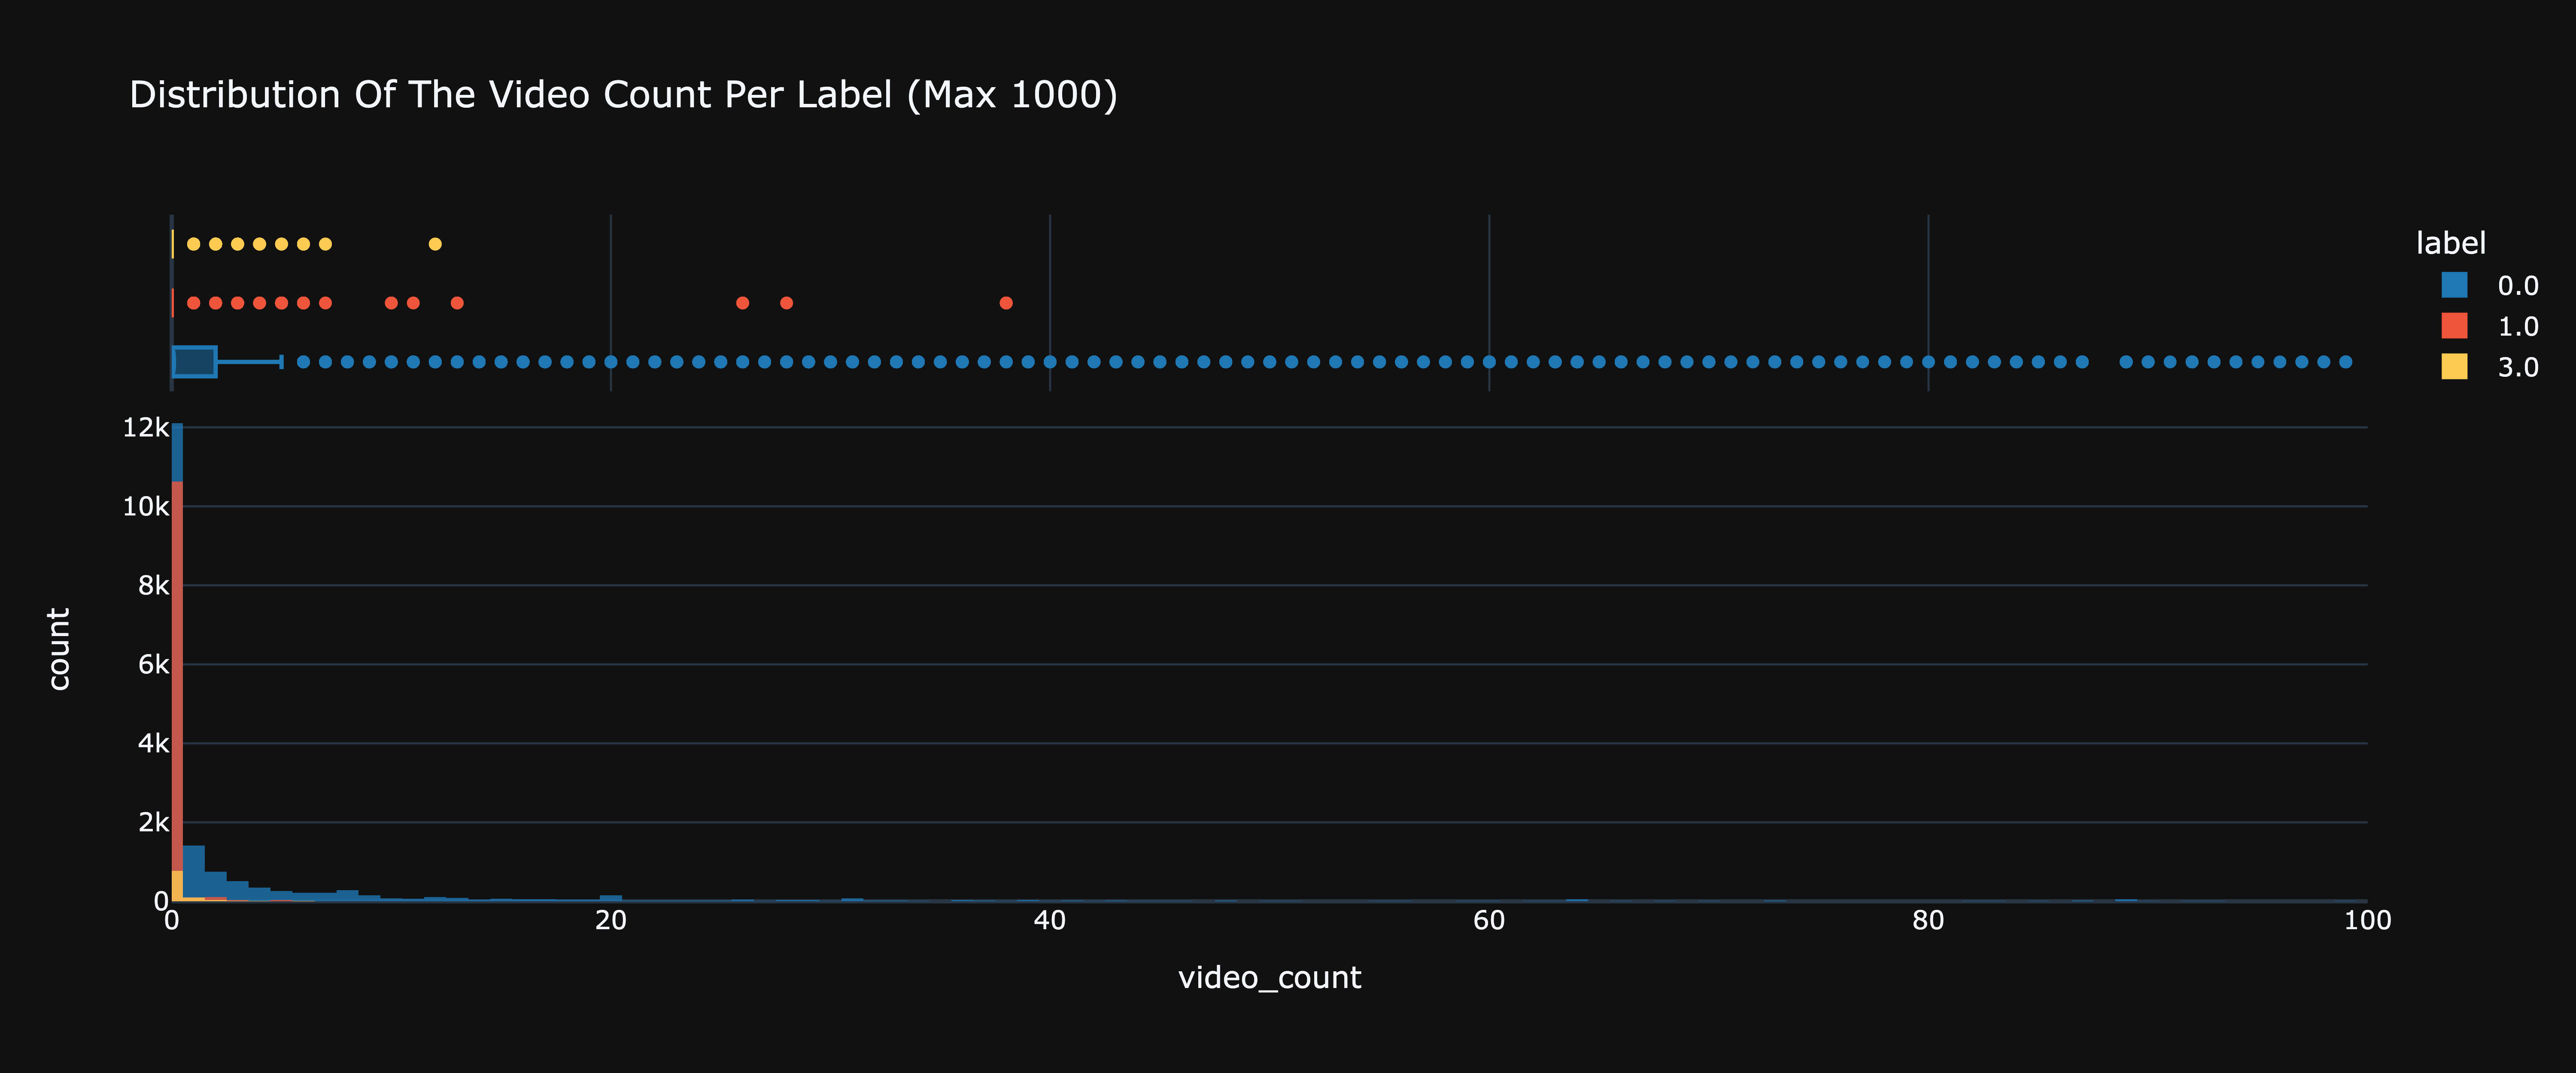

In [73]:
fig = px.histogram(df_main.query('video_count < 1000'), 
                   x="video_count", 
                   nbins=1000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the video count per label (max 1000)',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100)) # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig)

Unsurprisingly, most of the users have 0 video. The legit users have a very skewed distribution with a lot of outliers. 

#### 1.3.2 Highlight Reel Count

In [76]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('highlight_reel_count')

print('Post count described by label: ')
display(sub_df.style.format('{:,}'))
sv.save_plotly_fig(fig, 'fig')

Post count described by label: 


,all,0,1,3
count,"30,500","18,628","10,927",945
mean,2,3,0,9
std,12,15,1,12
min,0,0,0,0
25%,0,0,0,2
50%,0,0,0,7
75%,2,4,0,13
max,628,628,42,128


Link for interactability (plotly chart): http://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/summary_stats_per_label_for_column_highlight_reel_count.html


In [66]:
df_main = print_outliers(df_main, 'highlight_reel_count')

Lower bound: 0.0 - Upper bound: 5.0

4960 outliers found

Label: 0


,Condition,Count,Percentage
0,True,15133,81.2
1,False,3495,18.8


Label: 1


,Condition,Count,Percentage
0,True,10817,99.0
1,False,110,1.0


Label: 3


,Condition,Count,Percentage
0,False,571,60.4
1,True,374,39.6


In [81]:

fig = px.histogram(df_main.query('highlight_reel_count < 1000'), 
                   x="highlight_reel_count", 
                   nbins=1000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the highlight reel count per label',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100)) # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig, 'fig')

Link for interactability (plotly chart): http://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_highlight_reel_count_per_label.html


In [98]:
for i in range(5): 
    p = df_main.query(f'highlight_reel_count >= {i} and label == 3').shape[0] / df_main.query(f'label == 3').shape[0]
    print(f'{p:.0%} of the bots have {i} or more highlight reels')

100% of the bots have 0 or more highlight reels
80% of the bots have 1 or more highlight reels
76% of the bots have 2 or more highlight reels
74% of the bots have 3 or more highlight reels
72% of the bots have 4 or more highlight reels


Other tye of bot has its distribution quite different from both other groups. 80% of the other bots have highlight reels, quite an important feature for them.

### 1.5 Domain - 50% done

The domain column is the domain url that the users had in their bio bu

In [172]:
na_count = df_main['domain'].isna().sum()
print(f"The domain column has {na_count:,} ({na_count / df_main.shape[0]:.1%}) missing values (no link in bio).")

The domain column has 12,447 (40.8%) missing values (no link in bio).


In [225]:
sub_df = df_main.copy(deep=True)
sub_df['domain'] = sub_df['domain'].fillna('None')


df_domain_label_count = sub_df.groupby(['domain', 'label'], as_index=False).agg({'username': 'count'}).rename({'username': 'count'}, axis=1).sort_values('count', ascending=False)
df_domain_count = sub_df.groupby('domain', as_index=False).agg({'username': 'count'}).rename({'username': 'domain_count'}, axis=1)
sub_df = df_domain_label_count.merge(df_domain_count, on='domain', how='left')

sub_df['count_p'] = sub_df['count'] / sub_df['domain_count']
sub_df = sub_df.sort_values(['domain_count', 'count_p'], ascending=[True, False])

px.bar(sub_df.query('domain_count > 500'), 
    x='count_p', 
    y='domain', 
    barmode='stack', 
    color='label', 
    **plotly_kwargs
    )

In [222]:
sub_df.query('domain_count > 500')

,domain,label,count,domain_count,count_p
0,None,0.0,11102,12447,0.8919418333735036
5,None,1.0,767,12447,0.061621274202619106
6,None,3.0,578,12447,0.04643689242387724
1,linkr.bio,1.0,5069,5096,0.994701726844584
77,linkr.bio,3.0,23,5096,0.004513343799058085
162,linkr.bio,0.0,4,5096,0.0007849293563579278
2,bit.ly,1.0,1522,1570,0.9694267515923567
42,bit.ly,0.0,48,1570,0.030573248407643312
4,linktr.ee,1.0,956,1388,0.6887608069164265
12,linktr.ee,0.0,392,1388,0.2824207492795389


### 1.x Business/Verified - Done ✅

There are multiple columns like: `is_business_account`, `is_professional_account`, `category_enum`, `category_name`, `business_category_name`, `business_contact_method`

In [ ]:
business_columns = ['is_business_account', 'is_professional_account', 'category_enum', 'category_name', 'business_category_name', 'business_contact_method']

sub_df = df_main[business_columns + ['label']]

for col in business_columns: 
    col_na = sub_df[col].isna()
    if col_na.sum() != 0:
        sub_df[col] = sub_df[col].isna().astype(int)

sub_df.groupby(business_columns, as_index=False)['label'].count()

In [ ]:
df_business_groupby = df_main.groupby(['is_professional_account', 'is_business_account', 'label'], as_index=False)['username'].count()
df_business_groupby['count_%'] = df_business_groupby['username'] / df_business_groupby['username'].sum()

df_business_groupby.style.background_gradient()

Many bots are creating professional or business accounts. Seems like if you're a business, you're a professional but if you're pro, you're not necessarily a business. The highest combination is that most legit users and bots don't have a professional account. It's good to note that for the otherbots, there are as more accounts as professionals/business than normal accounts.

In [ ]:
px.sunburst(df_main.dropna(subset='category_enum').fillna('na'),
            path=['category_enum', 'category_name'],
            color='label',
            ).update_layout(uniformtext=dict(minsize=10, mode='hide'))

In [ ]:
# asdf

In [ ]:
fig = px.histogram(df_main, 
                    x='category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of category_name for bots and legit users')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
fig

In [ ]:
fig = px.histogram(df_main.query('label > 0'), 
                    x='category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of category_name for bots only')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
fig

In [ ]:
fig = px.histogram(df_main.query('label > 0'), 
                    x='business_category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of business_category_name for bots and legit users')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
fig

It's interesting to see the difference between the bots and the sex bots. Even though many have been miss labelled (they'll both be marked at 1 when developping the model) bet ween bot or otherbot, there is a significative distinction between how they identify themselves.

Other bots seems to be more entreupreuners, financial service or investment firm where bots are more video creator (you bet), personnal blog or gamer.

In [ ]:
df_main.query('label > 0')['category_name'].value_counts().sort_values(ascending=True)[df_main.query('label > 0')['category_name'].value_counts().sort_values(ascending=True).lt(12)].index

In [ ]:
# Keeping only binary columns
df_main = df_main.drop(['category_name', 'business_category_name', 'business_contact_method'], axis=1)

In [ ]:
df_main

### 
---

### 1.x Comment time difference WHATS THE AVERAG DIFFERENCE BETWEEN EACH POST? COULD BE UPLOADED SUPER FAST

In [ ]:
def round_or_int(val, **kwargs): 
    if pd.isna(val): 
        return val
    elif val == int(val): 
        return int(val) 
    else:
        return round(val, ndigits=kwargs['ndigits'])

def calculate_posts_time_diff_btw_each(date_concat): 
    if pd.isna(date_concat): 
        return date_concat
    dates = [pd.to_datetime(date) for date in date_concat.split(',')]
    dates = sorted(list(set(dates)))[:12]
    dates_diff = pd.Series(dates).diff().dt.seconds.dropna().reset_index(drop=True)
    dates_diff_summary = dates_diff.describe().apply(round_or_int, ndigits=2).to_dict()
    dates_diff_summary.update({'dates_diff': dates_diff.tolist(),
                               'unique_values': len(set(dates_diff)),
                               'total_values': len(dates_diff)
                               })

    # display(pd.DataFrame({i:[j] for i, j in dates_diff_summary.items()}))
    dates_diff_summary = {'dates_diff_' + i:j for i, j in dates_diff_summary.items()}
    return dates_diff_summary

df_main['posts_diff_btw_each_summary_seconds'] = df_main['posts_concat_posted_time'].parallel_apply(calculate_posts_time_diff_btw_each)
# calculate_posts_time_diff_btw_each(df_main.loc[1, 'posts_concat_posted_time'])
df_posts_diff_btw_each_summary = pd.json_normalize(df_main['posts_diff_btw_each_summary_seconds'])

In [ ]:
df_main = pd.concat([df_main, df_posts_diff_btw_each_summary], axis=1)
df_main.head()

In [ ]:
# sub_df = df_main[['dates_diff_follows_pattern', 'post_count', 'label']]

# fig = px.scatter_matrix(sub_df, color='label', title='Pairplot')
# sv.save_plotly_fig(fig)

In [ ]:
# # Describing column for each label
# sub_df, fig = df_main.describe_column_by_label('dates_diff_50%')

# print('dates_diff_50%: ')
# display(sub_df.style.format('{:,}'))
# fig

#### IV Changing values

### 1.x Pronouns

In [226]:
# Checking for missing values
for label in (0, 1, 3): 
    sub_df = df_main.query(f"label == {label}")
    p = sub_df['pronouns'].isna().sum() / sub_df.shape[0] * 100
    print(f'Label: {label} - % of users with pronouns: {p:.2f}%')

Label: 0 - % of users with pronouns: 96.81%
Label: 1 - % of users with pronouns: 99.94%
Label: 3 - % of users with pronouns: 99.68%


Most of the users having a pronoun are legit users and but some bots have it too. There are a ton of missing values (>98%) so I'll just create a flag for originally missing/not missing.

In [229]:
sub_df = df_main.copy(deep=True)
sub_df['pronoun_null'] = sub_df['pronouns'].isna().astype(int)

sub_df.groupby(['pronoun_null', 'label'], as_index=False)['username'].count() 

,pronoun_null,label,username
0,0,0.0,594
1,0,1.0,7
2,0,3.0,3
3,1,0.0,18034
4,1,1.0,10920
5,1,3.0,942


There are still 11 bots that have a pronoun. Which do they identify to you ask??

In [ ]:
df_main.pronouns.value_counts().head()

In [ ]:
pronouns = {"he": 'male', "him": 'male', "his": 'male', "himself": 'male', "she": 'female', "her": 'female', "hers": 'female', "herself": 'female'}

def find_gender(pronoun): 
    if pd.notna(pronoun):
        first_pronoun = re.split(',| ', pronoun)[0]
        try:
            return pronouns[first_pronoun]
        except KeyError: 
            return 'nonbinary'

df_main['pronouns'].apply(find_gender).value_counts()

In [ ]:
df_main = df_main.drop('pronouns', axis=1)

### Next

### Comment likes

In [ ]:
def outliers_bound(self, col):
    q1, q3 = self[col].quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def find_outliers(self, col, bounds=[]):
    '''Given a columns, return a pd.Series with True/False for each value'''
    if len(bounds) == 2: 
        lower_bound, upper_bound = bounds
    else: 
        lower_bound, upper_bound = outliers_bound(self, col)

    return self[col].fillna(self[col].quantile(.5)).apply(lambda x: not lower_bound <= x <= upper_bound)


def find_all_outliers(self, dtypes=None, columns=None, exclude=[]):
    # Add or remove column to the list
    if dtypes != None: 
        columns = list(self.select_dtypes(dtypes))
    elif isinstance(columns, str):
        columns = [columns]
    for col in exclude: 
        columns.remove(col)

    # Find outliers and concat
    base_series = pd.Series(['']*self.shape[0])
    for index, col in enumerate(columns): 
        col_outliers = find_outliers(self, col).map({True: col, False: ''})
        base_series = base_series.str.cat(col_outliers, sep=' ').str.strip()
        
    return base_series


find_outliers(df_main, 'comments_likes')

In [ ]:
df_main.outliers_bound('comments_likes')

In [ ]:
for x in df_main.describe_column_by_colcat('comments_likes'): 
    display(x)

In [ ]:
# def better_describe(self, column): 
#     data = {}
#     # data = {'count': [self[column].shape[0]],
#     #         'sum': [self[column].sum()],
#     #         }

#     # data.update({'min': [self[column].min()]})
#     for q in range(1, 100): 
#         data.update({f'{q}%': [self[column].quantile(q/100)]})
#     # data.update({'max': [self[column].max()]})
    

#     df = pd.DataFrame(data).T#.drop_duplicates(0, keep='first')
#     df['diff'] = df.iloc[::-1].diff()
#     df['var'] = [np.nan] + (df['diff'] / df[0] * -1).round(2).tolist()[:-1]

#     return df.query('var >= .1').round(2)


# better_describe(df_main, 'comments_likes').head(50)

* different quantile
* skewness
* inf values
* unique values
* null values
* sum
* quantile 
* count
* Min 
* max
* std
*

There is no doubts on that, bots comment the faster and it's their main strategy which makes sense, the sonner the comment the more reach it has. 

There is a clear distinction between the bots and the other bots. The bots are way more in volume 

In [ ]:
df_main.query('label == 3')['comments_likes']

In [ ]:
fig = px.box(df_main, 
             x='label', 
             y='comments_likes',
             color='label',
             **plotly_kwargs
             )

fig.update_layout(yaxis_range=(0, 600))

In [ ]:
# df = px.data.iris()
# fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", marginal_y="violin",
#            marginal_x="box", trendline="ols", template="simple_white")
# fig.show()

### 1.x Comment time diff

In [ ]:
df_main

In [ ]:
fig = px.violin(df_main, 
                x='label', 
                y='comment_time_difference',
                color='label',
                box=True, 
                # kde=1,
                # meanline_visible=True,
                # points='all',
                **plotly_kwargs
                )

fig.update_layout(yaxis_range=(0, 450))
fig.update_traces(bandwidth=100, selector=dict(type='violin'))

fig

There's a clear distinction between the different labels: legit users tend to comment, even after some time where the bots are way faster. They comment only

The collected data is not representative of the overall population but I think that by collecting more, I would have just extended the range of the `0` class.

### Investigate

In [ ]:
# adsf

In [12]:
column = 'comments_likes'
cols_co_keep = [column] + ['username', 'biography', 'label', 'labelling_technique', 'domain', 'comment']

sub_df = df_main.query('label > 0').sort_values(column, ascending=False)[cols_co_keep].drop_duplicates()
# display(df_main.head(50))
username = 'axiomatic-merciful-mayfly'
# print(sl.load_table('select '))
# print(username)

display(sl.load_labels(include_all=True).query('username == @username'))
# display(sl.load_table('username_mapping').query('cooler_name == @username'))
# df_main.query('username == @username')


# sub_df.query('comments_likes > 1000 and label > 0')

,username,label,time,labelling_technique
28998,axiomatic-merciful-mayfly,3.0,2023-02-06 16:36:53.713283,domain


In [13]:
df_main.query('biography.str.contains("skate") and label > 0')

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,is_verified,label,labelling_technique,binary_label
3377,axiomatic-merciful-mayfly,"mostly skate, sneakers, and art stuff.\nday jo...","mostly skate, sneakers, and art stuff.\nday jo...",,0.0,0.0,"1,218.0",765.0,None,crypto.com,"lol, nice tackle drew","lol, nice tackle drew",121,,0,0,271,646.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,102.258217592258,"2,454.197222214192",0.0,3.0,domain,1.0
28327,axiomatic-merciful-mayfly,"mostly skate, sneakers, and art stuff.\nday jo...","mostly skate, sneakers, and art stuff.\nday jo...",,0.0,0.0,"1,218.0",765.0,None,crypto.com,jokic,jokic,14,,0,0,2932,646.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,102.258217592258,"2,454.197222214192",0.0,3.0,domain,1.0


In [10]:
df_main.query('username == "axiomatic-merciful-mayfly"')

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,is_verified,label,labelling_technique,binary_label
3377,axiomatic-merciful-mayfly,"mostly skate, sneakers, and art stuff.\nday jo...","mostly skate, sneakers, and art stuff.\nday jo...",,0.0,0.0,"1,218.0",765.0,None,crypto.com,"lol, nice tackle drew","lol, nice tackle drew",121,,0,0,271,646.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,102.258217592258,"2,454.197222214192",0.0,3.0,domain,1.0
28327,axiomatic-merciful-mayfly,"mostly skate, sneakers, and art stuff.\nday jo...","mostly skate, sneakers, and art stuff.\nday jo...",,0.0,0.0,"1,218.0",765.0,None,crypto.com,jokic,jokic,14,,0,0,2932,646.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,102.258217592258,"2,454.197222214192",0.0,3.0,domain,1.0


In [ ]:
asdf

### Done investigating

## 2.0 Multi variate analysis - Past this point the data is entirely clean and ready for ML.

In [ ]:
# asdf

In [ ]:
# Removing columns for now as there are way too many and feel overwhelmed
cols_to_remove = ['posts_sum', 'posts_avg', 'posts_max', 'posts_min', 'posts_con', 'dates_dif']
cols_to_remove = [col for col in df_main.columns if any([x in col for x in cols_to_remove])] + ['biography', 'biography_wo_emoji', 'biography_emoji', 'domain', 'comment', 'comment_wo_emoji',
                                                                                                'comment_emoji', 'labelling_technique', 'posts_diff_btw_each_summary_seconds']
cols_to_keep = [col for col in df_main.columns if col not in cols_to_remove]

df_main = df_main[cols_to_keep]
df_main.head()

In [ ]:
df_main

### 2.1 Pair plot (remove outliers)

In [ ]:
df_main.columns

In [ ]:

# cols = ['follow_count', 'follower_count', 'post_count', 'video_count', 'is_private', 'binary_label', 'posts_hours_diff']
# sns.pairplot(df_main[cols], 
#              hue="binary_label")

### 2.2 Follow count & follow 

In [ ]:
# df_main.query('comment_time_difference > 74 and label > 0').sort_values('comment_time_difference', ascending=False)[['username', 
#                                                                                                         'post_count', 
#                                                                                                         'comment_time_difference', 
#                                                                                                         'biography', 
#                                                                                                         'label', 
#                                                                                                         'labelling_technique']].head(40)

px.scatter_3d(df_main,
              x='follow_count',
              y='follower_count',
              z='label',
              color='label')

#### 1.1.6 Pairplot

In [ ]:
asdfasdfsafasd

#### 1.1.7

### 2.x Comment likes vs comment time diff

In [ ]:
sub_df = df_main.copy(deep=True)


# sub_df[]

fig = px.scatter(sub_df,
           x='comment_time_difference', 
           y='comments_likes',
           color='label')
# you can be casual and nice to read but remember that the public is from an age of 21 to 100 years old. 
fig.update_layout()

### ?

In [ ]:
percent99 = df_main['follower_count'].quantile(0.9)
sub_df = df_main.query('follower_count < @percent99')


fig = px.histogram(sub_df, 
                   x="follower_count", 
                   nbins=100,
                   color="label",
                   marginal="box", # or violin, rug
                   )

fig.update_layout(barmode='overlay')

In [ ]:
import plotly.figure_factory as ff
import numpy as np

sub_df = df_main.query('follow_count.notna()')


labels = ['0', '1', '3']
hist_data = [sub_df[sub_df['label'] == int(x)]['follow_count'] for x  in labels]

fig = ff.create_distplot(hist_data, labels,
                         bin_size=[200, 200, 200], show_curve=True)

# Add title
fig.update(layout_title_text='Hist and Rug Plot')
fig.show()

## Export df_ml

In [ ]:
# asdlf

In [ ]:
df_ml = df_main.copy(deep=True)

# removing na on label,
df_ml = df_ml.dropna(subset='label')

# df_ml['biography'] = df_ml['biography'].fillna('')
# df_ml['domain'] = df_ml['domain'].fillna('')
# df_ml['pronouns'] = df_ml['pronouns'].fillna('')


# removing agg columns 
df_ml['posts_na_flag'] = df_ml['posts_days_diff'].isna().astype(int)
for col in df_ml.columns: 
    if (col[:6] == 'posts_' and 'concat' not in col and 'posted_time' not in col) or 'dates_diff' in col: 
        try:
            df_ml[col] = df_ml[col].fillna(df_ml[col].mean())
        except: 
            df_ml = df_ml.drop(col, axis=1)
    elif 'concat ' in col or 'posted_time' in col: 
        df_ml = df_ml.drop(col, axis=1)

# Adding comment feature 
# df_ml['comment_length'] = df_ml['comment'].str.len()

# removing na on follow count
df_ml = df_ml.dropna(subset='follow_count')
# df_ml['biography'] = df_ml['biography'].apply(lambda x: 1 if len(x) > 0 else 0)
# df_ml['domain'] = df_ml['domain'].apply(lambda x: 1 if len(x) > 0 else 0)
# df_ml['pronouns'] = df_ml['pronouns'].apply(lambda x: 1 if len(x) > 0 else 0)
df_ml['label'] = df_ml['label'].astype(float)
for col in ['pronouns', 'domain', 'business_contact_method', 'business_category_name', 'category_name', 'category_enum', 'posts_concat_likes', 'posts_concat_is_video', 'posts_concat_video_views', 'posts_concat_comments', 'posts_concat_tagg_count', 'labelling_technique', 'outlier']: 
    df_ml = df_ml.drop(col, axis=1)


In [ ]:
df_ml['label'].value_counts()

In [ ]:
df_ml.isna().sum().tail(40)

In [ ]:
s = df_ml.isna().sum().head(50).eq(0)
cols = s[s].index
cols

In [ ]:
df_ml.to_sql('ml', con, if_exists='replace', index=False)

In [ ]:
# # DUMB ML TEST 
# df_dumb_ml = df_ml.copy(deep=True)


# for col in df_ml.columns: 
#     # print(len(df_ml[col].unique()))
#     unique_vals = df_dumb_ml[col].unique()
#     if 2 < len(unique_vals) < 10000:
#         for x in df_dumb_ml[col].describe().iloc[1:-1]: 
#             df_dumb_ml[col + str(x)] = df_dumb_ml[col].ge(x)
        
#         df_dumb_ml.drop(col, axis=1)

# df_dumb_ml.to_sql('dumb_ml', con, if_exists='replace', index=False)
# df_dumb_ml.shape

In [ ]:
df_ml.head()

### Quick ML
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBClassifier, DMatrix
import shap

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBClassifier, DMatrix
import shap

In [ ]:
df_ml = sl.load_table('dumb_ml').query('label.isin((0, 1, 3))')
df_ml = sl.load_table('ml').query('label.isin((0, 1, 3))')
df_ml['label'] = df_ml['label'].apply(lambda x: 1 if x == 3 else x)
legit_count, bot_count = df_ml['label'].value_counts()
print(f'{legit_count = }\n{bot_count = }')
print(df_ml.shape)

In [ ]:
df_ml.label.value_counts()

In [ ]:
df_ml.head()

In [ ]:
df_ml = df_ml[['follow_count', 'follower_count', 'comments_likes', 'post_count', 'comment_time_difference', 'label', 'username']]

In [ ]:
# Split data
X = df_ml.drop(['label', 'username'], axis=1)
y = df_ml['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test =X.iloc[:X.shape[0] // 5 * 4, :], X.iloc[X.shape[0] // 5 * 4:, :], y[:y.shape[0] // 5 * 4], y[y.shape[0] // 5 * 4:]

# Create a random forest classifier
clf = DecisionTreeClassifier(max_depth=1000, criterion='entropy', random_state=42)
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf = XGBClassifier(n_estimators=1000,        
                    n_jobs=-1,
                    eval_metric='auc',
                    random_state=42
                    )

clf.fit(X_train, 
        y_train
        )

# clf.get_params()

In [ ]:
# for x in range(1, 10):
decision_threshold = sm.threshold_finder(model = clf, X = X_test, y_true = y_test)
print(decision_threshold)
y_pred_proba = [x[1] for x in clf.predict_proba(X_test)]
y_pred = (pd.Series(y_pred_proba) > decision_threshold).astype(int)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Test the classifier on the test data
for metric in [accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score]:
    
    try: 
        score = metric(y_test, y_pred, average='weighted')
        score_inverse = metric(y_test.eq(0), y_pred.eq(0), average='weighted')
        diff = metric(y_train, y_pred_train) - metric(y_test, y_pred, average='weighted')
        diff_inverse = metric(y_train.eq(0), pd.Series(y_pred_train).eq(0)) - metric(y_test.eq(0), y_pred.eq(0), average='weighted')
        w = 'Weighted'
    except: 
        score = metric(y_test, y_pred)
        score_inverse = metric(y_test.eq(0), y_pred.eq(0))
        diff = metric(y_train, y_pred_train) - metric(y_test, y_pred)
        diff_inverse = metric(y_train.eq(0), pd.Series(y_pred_train).eq(0)) - metric(y_test.eq(0), y_pred.eq(0))
        w = ''

    print(w, f'{metric.__name__.title()}: {score:.4f}\tDiff: {diff:.4f}\t\tScore inverse: {score_inverse:.4f}\t{diff_inverse:.4f}')

# print('\n\n\n\n\n\n\n\n')

In [ ]:
# sdaf

#### Model explainer

In [ ]:
import shap

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np

%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


In [ ]:
# if type(clf) == RandomForestClassifier: 
#     explainer = shap.TreeExplainer(clf)
#     shap_values = explainer(X)

In [ ]:
# shap_values

In [ ]:
# explainer.expected_value

In [ ]:
# shap.dependence_plot(1, shap_values, X)


In [ ]:
# clf ==

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

In [ ]:
# asdf

In [ ]:
# X,y = shap.datasets.adult()
# X_display,y_display = shap.datasets.adult(display=True)

In [ ]:
# display(shap.summary_plot(shap_values, X_test))
# display(shap.summary_plot(shap_values, X_test, plot_type="bar"))
# display(shap.summary_plot(shap_values, X_test, plot_type="dot"))
# display(shap.dependence_plot("feature_name", shap_values, X_test))

In [ ]:
# explainer = ClassifierExplainer(clf, X_test, y_test, 
#                                 cats=['Deck', 'Embarked',
#                                     {'Gender': ['Sex_male', 'Sex_female', 'Sex_nan']}],
#                                 cats_notencoded={'Embarked': 'Stowaway'}, # defaults to 'NOT_ENCODED'
#                                 # descriptions=feature_descriptions, # adds a table and hover labels to dashboard
#                                 labels=['Not survived', 'Survived'], # defaults to ['0', '1', etc]
#                                 idxs = X_test.columns, # defaults to X.index
#                                 index_name = "Passenger", # defaults to X.index.name
#                                 target = "Survival", # defaults to y.name
#                                 )

# db = ExplainerDashboard(explainer, 
#                         title="Titanic Explainer", # defaults to "Model Explainer"
#                         shap_interaction=False, # you can switch off tabs with bools
#                         )
# db.run(port=8050)

In [ ]:
# viz_model = dtreeviz.model(clf, tree_index=1,
#                            X_train=X_train, y_train=y_train,
#                            feature_names=X_train.columns,
#                            target_name=['label'], class_names=[0, 1])

# viz_model.view()

In [ ]:
# viz_model.view()

#### Shap

In [ ]:
# asdf

In [ ]:
xgb_explainer = shap.TreeExplainer(
    clf, X, feature_names=X.columns.tolist()
)

In [ ]:
booster_xgb = clf.get_booster()
shap_values_xgb = booster_xgb.predict(DMatrix(X, y), 
                                      pred_contribs=True)

shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

In [ ]:
pd.DataFrame(shap_values_xgb, columns=X.columns.tolist()).head().median(axis=0).abs().sort_values(ascending=False)

In [ ]:
X

In [ ]:
pd.DataFrame(shap_values_xgb, columns=X.columns)

In [ ]:
# asdf

In [ ]:
shap.summary_plot(shap_values_xgb, X, feature_names=X_train.columns, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values_xgb, X, feature_names=X_train.columns);

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

In [ ]:
shap.approximate_interactions(col, shap_values, X)

In [ ]:
# for column in df_ml: 
#     if column in ('username'):
#         continue
#     display(shap.dependence_plot(column, shap_values_xgb, X, interaction_index="auto"))



for col in ['follow_count', 'comments_likes', 'follower_count']:
    # for x in (0, 1):
        # if x == 11: 
        #     shap.dependence_plot(f'rank({i})', shap_values, X, interaction_index=None)
        # else: 
    inds = shap.approximate_interactions(col, shap_values, X)

    # make plots colored by each of the top three possible interacting features
    for i in range(3):
        shap.dependence_plot(col, shap_values, X, interaction_index=inds[i])

    # figure = pl.gcf()
        pl.savefig(f"{col}{i}.svg",dpi=700)
    # display(f.show())
    # break

In [ ]:
# interactions_xgb = booster_xgb.predict(DMatrix(X, y), pred_interactions=True
# )

# shap_values_xgb = booster_xgb.predict(DMatrix(X, y), pred_contribs=True)

In [ ]:
shap_values_xgb = booster_xgb.predict(DMatrix(X, y), 
                                      pred_contribs=True)

In [ ]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]

In [ ]:
top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

In [ ]:
top_10_inter_feats

In [ ]:
top_10_inter_vals

In [ ]:
import matplotlib.pyplot as plt

def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    

top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X.columns, interactions_xgb, 10
)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

In [ ]:
os.system('say "ml done"')

## Playground

## 0.x Mid playground

### III finding outliers

In [ ]:
df_main.select_dtypes(['int', 'float']).head(1)

In [ ]:
# for x in df_main.select_dtypes(['int', 'float']): 
#     print(f"'{x}',")

In [ ]:
def outliers_bound(self, col):
    q1, q3 = self[col].quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def find_outliers(self, col, bounds=[]):
    '''Given a columns, return a pd.Series with True/False for each value'''
    if len(bounds) == 2: 
        lower_bound, upper_bound = outliers_bound(col)
    else: 
        lower_bound, upper_bound = bounds

    return self[col].fillna(self[col].quantile(.5)).apply(lambda x: lower_bound <= x <= upper_bound if pd.notna(x) else False)


def find_all_outliers(self, dtypes=None, columns=None, exclude=[]):
    # Add or remove column to the list
    if dtypes != None: 
        columns = list(self.select_dtypes(dtypes))
    elif isinstance(columns, str):
        columns = [columns]
    for col in exclude: 
        columns.remove(col)

    # Find outliers and concat
    base_series = pd.Series(['']*self.shape[0])
    for index, col in enumerate(columns): 
        col_outliers = find_outliers(self, col).map({True: col, False: ''})
        base_series = base_series.str.cat(col_outliers, sep=' ').str.strip()
        
    return base_series
    

# columns = ['follow_count', 'follower_count', 'comments_likes', 'comment_time_difference',  'post_count',  'video_count',  'highlight_reel_count',  'posts_minutes_diff']
# df_main['has_outliers'] = find_all_outliers(df_main, columns=columns)

In [ ]:
# find_outliers(df_main, 'follow_count').value_counts()

### III dendrogram

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


# Calculate the distance between each sample
# You have to think about the metric you use (how to measure similarity) + about the method of clusterization you use (How to group cars)
Z = linkage(df_main[[col for col in df_main.columns if 'post' not in col]].select_dtypes(['int', 'float']), 'ward')